# Registration of Planet to Sentinel-2 ARD

### Import Packages

In [3]:
# Import packages

from pathlib import Path
from arosics import COREG, COREG_LOCAL, DESHIFTER
from geoarray import GeoArray
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os

### Load the Reference Image

In [5]:
# Select and the image/title of interest from Sentinel-2

basemap_file = Path('F:/TRAINING/level3_red/X0016_Y0024/2016-2022_182-243_HL_TSA_SEN2L_RED_FBY.tif') #This is the NAIP scene of 2019 for the title of interest
reference = GeoArray(str(basemap_file))

# Plot raster
# reference.show(figsize = (15, 15))

### Load Target Image

In [9]:
# Select and the image/title of interest from Planet

target_file = Path('F:/TRAINING/Planet/Cedar-Creek/2021/projected/20210812_161946_93_241d_3B_AnalyticMS_SR_harmonized.tif') #This is the average RED band for the groing period of 2019
target = GeoArray(str(target_file))

# Plot raster
#target.show(figsize = (15, 15))

### Coregistration to a Basemap Image

In [10]:
# Sometimes the projections does not match. Let's force them to be the same regardless if they are equal.
if reference.projection == target.projection:
    reference.projection = target.projection
else:
    print("Stop, you need to check the projection to continue")    

In [18]:
# Setup parameters for tiepoint detection and affine transformation factor calculation
coreg_kwargs = {
    'grid_res': 500, # Tie point spacing in x-direction, in terms of target image pixels
    'window_size': (500, 500), # Size of matching window
    'nodata': (-9999, 0), # No-data values for reference & target images
    'max_iter': 8,
    'r_b4match': 6, # Reference band for matching
    's_b4match': 3, # Target band for matching
    'CPUs': 4,      # For Ubuntu only
    'max_shift': 1000,
    'min_reliability': 80
}

In [19]:
# Apply local image coregistration
CRL = COREG_LOCAL(reference, target, **coreg_kwargs)

with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'): # Ignore AROSICS complaining
    result = CRL.correct_shifts()

Calculating footprint polygon and actual data corner coordinates for reference image...


Polygonize progress     |==================================================| 100.0% Complete  => 0:00:00


Bounding box of calculated footprint for reference image:
	(199292.51690292917, 705980.1870542851, 229292.51690292917, 735980.1870542851)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...


Polygonize progress     |==================================================| 100.0% Complete  => 0:00:01


Bounding box of calculated footprint for image to be shifted:
	(193800.79106927902, 697698.9521332582, 234438.67243590436, 727291.2021887869)
Matching window position (X,Y): 213416.02645804352/715063.7239939728
Initializing tie points grid...
Equalizing pixel grids and projections of reference and target image...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Calculating tie point grid (241 points) using 4 CPU cores...


	progress: |==================================================| 100.0% Complete  => 0:00:21


Found 237 matches.
Performing validity checks...
7 tie points flagged by level 1 filtering (reliability).
4 tie points flagged by level 2 filtering (SSIM).


C:\Users\guzman\Anaconda3\envs\arosics\lib\site-packages\arosics\DeShifter.py:291: UserWarning: 
The coordinate grid of 20210812_161946_93_241d_3B_AnalyticMS_SR_harmonized cannot be aligned to the desired grid because their pixel sizes are not exact multiples of each other (input [X/Y]: 2.9016838294719824/3.102053452587035; desired [X/Y]: 10.0/10.0). Therefore the original grid is chosen for the resampled output image. If you don´t like that you can use the 'out_gsd' or 'match_gsd' parameters to set an appropriate output pixel size or to allow changing the pixel size.

  warnings.warn("\nThe coordinate grid of %s cannot be aligned to the desired grid because their pixel "
Translating progress |====----------------------------------------------| 7.3% Complete  => 0:00:00

17 tie points flagged by level 3 filtering (RANSAC)
209 valid tie points remain after filtering.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:07


Note: array has been downsampled to 1000 x 700 for faster visualization.


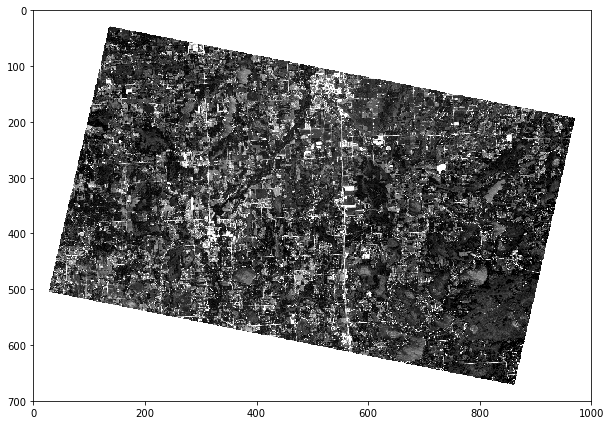

C:\Users\guzman\Anaconda3\envs\arosics\lib\site-packages\py_tools_ds\geo\projection.py:169: RuntimeWarning: Could not find a suitable EPSG code for the input WKT string.
  warnings.warn('Could not find a suitable EPSG code for the input WKT string.', RuntimeWarning)


Note: array has been downsampled to 1000 x 700 for faster visualization.


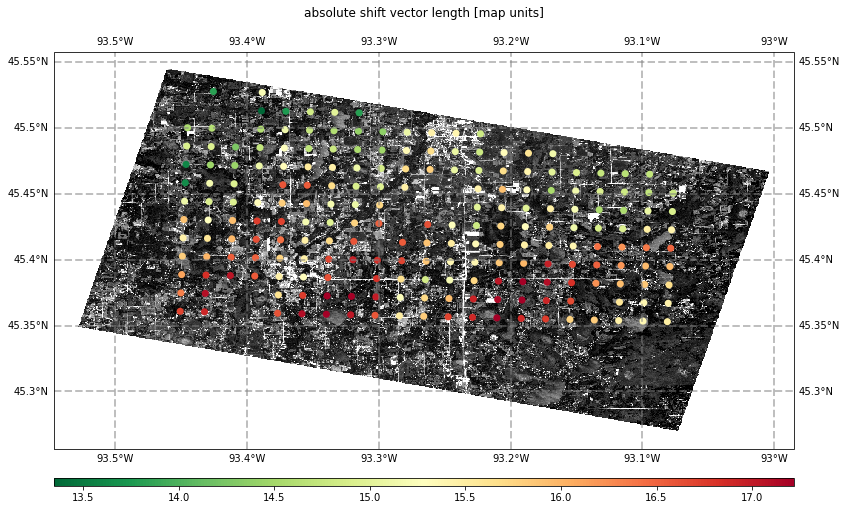

In [20]:
# Show the corrected target image geoarray
result['GeoArray_shifted'].show(figsize = (10, 15))

# Show tie points on top of the target image
CRL.view_CoRegPoints()

### Applying Calculated Shifts

In [21]:
# Apply previously-calculated shifts to the full-band image
deshifter = DESHIFTER(target, CRL.coreg_info)

# Warp the full-band image "with the cubic convolution resampling"
target_shifted_all_bands = deshifter.correct_shifts()

# Get shifted GeoArray
target_geoarray_shifted_all_bands = target_shifted_all_bands['GeoArray_shifted']

# Set file path to shifted image
target_file_shifted_all_bands = Path('F:/TRAINING/Planet/Cedar-Creek/2021/coregistered/20210812_161946_93_241d_3B_AnalyticMS_SR_harmonized.tif')

# Save the shifted image into GTiff, use this image for manual assessment.
target_geoarray_shifted_all_bands.save(str(target_file_shifted_all_bands),
                                       fmt = 'GTiff')

Translating progress |===============-----------------------------------| 29.0% Complete  => 0:00:00

Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:06


Writing GeoArray of size (10398, 14848, 4) to F:\TRAINING\Planet\Cedar-Creek\2021\coregistered\20210812_161946_93_241d_3B_AnalyticMS_SR_harmonized.tif.
